In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [124]:
data_base = pd.read_excel('./DATA_preprocess_EDA_base/big_merge_V2_meteo_SAT.xlsx').drop('Unnamed: 0', axis=1)

In [110]:
data_base.head()

,PARCELLE,LAT,LON,ALT,PRODREG,HT_VEG,DATE,SLOPE25,ASPECT25,ORIENTATION,...,TAVE_AVG,TAVE,TAVE_GROWTH,PRCP_S_S,PRCP_G_S,NDVI,EVI,NDMI,NDWI,DSWI
0,51,47.781623,8.612822,715.918970,1,3,1984-04-10,58.407726,67.342415,E,...,NaN,NaN,NaN,0.000000,0.000000,0.3779,0.0146,0.2264,-0.3325,0.4705
1,51,47.781623,8.612822,715.918970,1,3,1994-10-19,58.407726,67.342415,E,...,8.8859,9.026806,13.84776,117.278617,51.835496,0.4992,0.0160,0.2705,-0.4653,0.6865
2,51,47.781623,8.612822,715.918970,1,3,2011-11-09,58.407726,67.342415,E,...,9.0502,4.555499,14.64318,120.598667,57.801233,-0.1255,-0.0138,0.0107,0.1121,-0.0810
3,51,47.781623,8.612822,715.918970,1,3,2005-11-01,58.407726,67.342415,E,...,9.0457,3.006553,14.37088,122.999273,55.547082,0.6923,0.0272,0.2294,-0.6305,0.9579
4,384,47.736528,8.625154,563.829759,1,2,1995-07-10,55.683254,253.354935,O,...,8.9951,19.793490,13.83959,122.675652,55.827235,0.5552,0.0149,0.2017,-0.4864,0.6996


PREPROCESSING _ Code base for models temporal predictions

Ici, features engineering (création de nouvelles features à partir de la liste connues):

In [69]:
# adding aridity index
#data_base["AI"] = data_base['PRCP_GROWTH'] / data_base['TAVE_GROWTH']
# adding H/D index
#data_base["H_D"] = data_base['HAUTEUR_ARBRE'] / data_base['DBH']

### Choix TARGET et Features :

Target :

In [111]:
TARGET = ['ALT'] #exemple

Features :

In [112]:
# --- PAST --- 
# Attention : on peut, logiquement, inclure la TARGET... (connue dans le passé)
cat_strict = [] #exemple
cat_ord_miss = ['DEGRAD_PPL', 'MELANGE', 'SURF_TROU_AER'] #exemple
numerics = ['HT_VEG','SURF_TER_HA', 'NDVI', 'EVI', 'NDMI', 'NDWI', 'DSWI', 'FEUILL_PER', 'CONIF_PER', 'TIGES_VIV_H', 'DEG_SUR_PER'] #exemple

# --- FUTURE KNOWN ---
# Attention : logiquement les features, potentiellement connues dans le futur ci-dessous sont aussi répertoriées ci-dessus dans le passé
add_cat_IFN_stable = ['TAUX_COUV_RAJ', 'TYPE_FORET305', 'TYP_RAJ_PPL', 'ESPECE_DOM', 'FEU_RES', 'NIV_DEV']
add_cat_ord_IFN_stable = ['DEGRAD_PPL', 'MELANGE', 'SURF_TROU_AER']
add_IFN_numerics_stable = ['NB_SAISON', 'HT_VEG', 'SURF_TER_HA', 'UNIT_VOL_BOIS_MANQUANT', 'UNIT_ACCR', 'FEUILL_PER', 'CONIF_PER', 'TIGES_VIV_H', 'DEG_SUR_PER'] #exemple
# données potentiellement connues car stables par parcelles :
#['LAT', 'LON', 'ALT', 'PRODREG', 'HT_VEG', 'SLOPE25', 'ASPECT25', 'ORIENTATION', 'PERF_CROI', 'QUAL_STATION', 'UNIT_VEG_FINE',
# 'UNIT_VEG_GROS', 'PROCESS_SILVA', 'PERI_CHENAUX', 'PERI_COULEES','PERI_AVALANCH', 'PERI_CHUTES', 'ETAGE', 'ENDOMMAGEMENT','NB_DEGAT_ARBRE']
# + données extrapolées grâce à des technologies prometteuses (satellites ?)....

add_meteo_known = []

add_SAT_known = ['NDVI', 'EVI', 'NDMI', 'NDWI', 'DSWI']

In [113]:
features_past = numerics + cat_strict + cat_ord_miss
features_future = add_cat_IFN_stable + add_cat_ord_IFN_stable + add_IFN_numerics_stable + add_meteo_known + add_SAT_known

In [114]:
data_LFI1 = data_base.loc[data_base['LFI']=='LFI1',:].sort_values('PARCELLE')
data_LFI2 = data_base.loc[data_base['LFI']=='LFI2',:].sort_values('PARCELLE')
data_LFI3 = data_base.loc[data_base['LFI']=='LFI3',:].sort_values('PARCELLE')
data_LFI4 = data_base.loc[data_base['LFI']=='LFI4',:].sort_values('PARCELLE')

In [115]:
future_feat_names = []
add_cat_strict_feat_names = []
add_cat_ord_feat_names = []
add_numerics_feat_names = []

for cat in features_future:
    lfi2_list = data_LFI2[cat].to_list()
    lfi3_list = data_LFI3[cat].to_list()
    lfi4_list = data_LFI4[cat].to_list()
    data_LFI1[cat + "_f"] = lfi2_list
    data_LFI2[cat + "_f"] = lfi2_list
    data_LFI3[cat + "_f"] = lfi2_list
    future_feat_names.append(cat + '_f')
    if cat in add_cat_ord_IFN_stable:
        add_cat_ord_feat_names.append(cat + '_f')
    elif cat in add_cat_IFN_stable:
        add_cat_strict_feat_names.append(cat + '_f')
    else:
        add_numerics_feat_names.append(cat + '_f')


In [116]:
data_red = pd.concat([data_LFI1, data_LFI2, data_LFI3], axis=0)[features_past + future_feat_names]
Y = pd.concat([data_LFI2[TARGET], data_LFI3[TARGET], data_LFI4[TARGET]], axis = 0)

In [117]:
data_red.head()

,HT_VEG,SURF_TER_HA,NDVI,EVI,NDMI,NDWI,DSWI,FEUILL_PER,CONIF_PER,TIGES_VIV_H,...,UNIT_ACCR_f,FEUILL_PER_f,CONIF_PER_f,TIGES_VIV_H_f,DEG_SUR_PER_f,NDVI_f,EVI_f,NDMI_f,NDWI_f,DSWI_f
0,3,27.79,0.3779,0.0146,0.2264,-0.3325,0.4705,NaN,NaN,590.0,...,11.9,NaN,NaN,650.0,NaN,0.4992,0.0160,0.2705,-0.4653,0.6865
5,2,53.38,0.2861,0.0071,0.3293,-0.2327,0.3518,NaN,NaN,400.0,...,10.8,NaN,NaN,340.0,NaN,0.5552,0.0149,0.2017,-0.4864,0.6996
9,2,26.70,0.6749,0.0219,0.2021,-0.5865,0.8626,NaN,NaN,320.0,...,12.3,NaN,NaN,220.0,NaN,0.5633,0.0153,0.1727,-0.5002,0.6852
14,2,0.00,0.6092,0.0201,0.1112,-0.5143,0.6521,NaN,NaN,0.0,...,1.4,NaN,NaN,250.0,NaN,0.6059,0.0197,0.2269,-0.5588,0.8384
19,2,23.32,0.7039,0.0245,0.1949,-0.5983,0.8834,NaN,NaN,150.0,...,5.6,NaN,NaN,200.0,NaN,0.6012,0.0184,0.2029,-0.5486,0.7902


Traitement des données catégorielles ordonnées en numériques (gestion des "-1" éventuels) :

In [118]:
feats_cat_ord = cat_ord_miss + add_cat_ord_feat_names
for cat in feats_cat_ord:
  data_red[cat] = data_red[cat].apply(lambda v : v if v!=-1 else np.nan)

LISTE DES FEATURES NUMERIQUES ET CATEGORIELLES EN VUE DU PREPROCESSING DE MODELE :

In [119]:
numerics_features = numerics + feats_cat_ord + add_numerics_feat_names
feats_cat_strict = cat_strict + add_cat_strict_feat_names

In [120]:
evol_feats_names = []
for col in numerics:
    data_red[f'{col}_evol'] = (data_red[f'{col}_f'] - data_red[col]) / data_red['NB_SAISON_f']
    evol_feats_names.append(f'{col}_evol')

In [121]:
data_red_red = data_red[evol_feats_names + add_numerics_feat_names + feats_cat_ord + add_cat_strict_feat_names]

<AxesSubplot:>

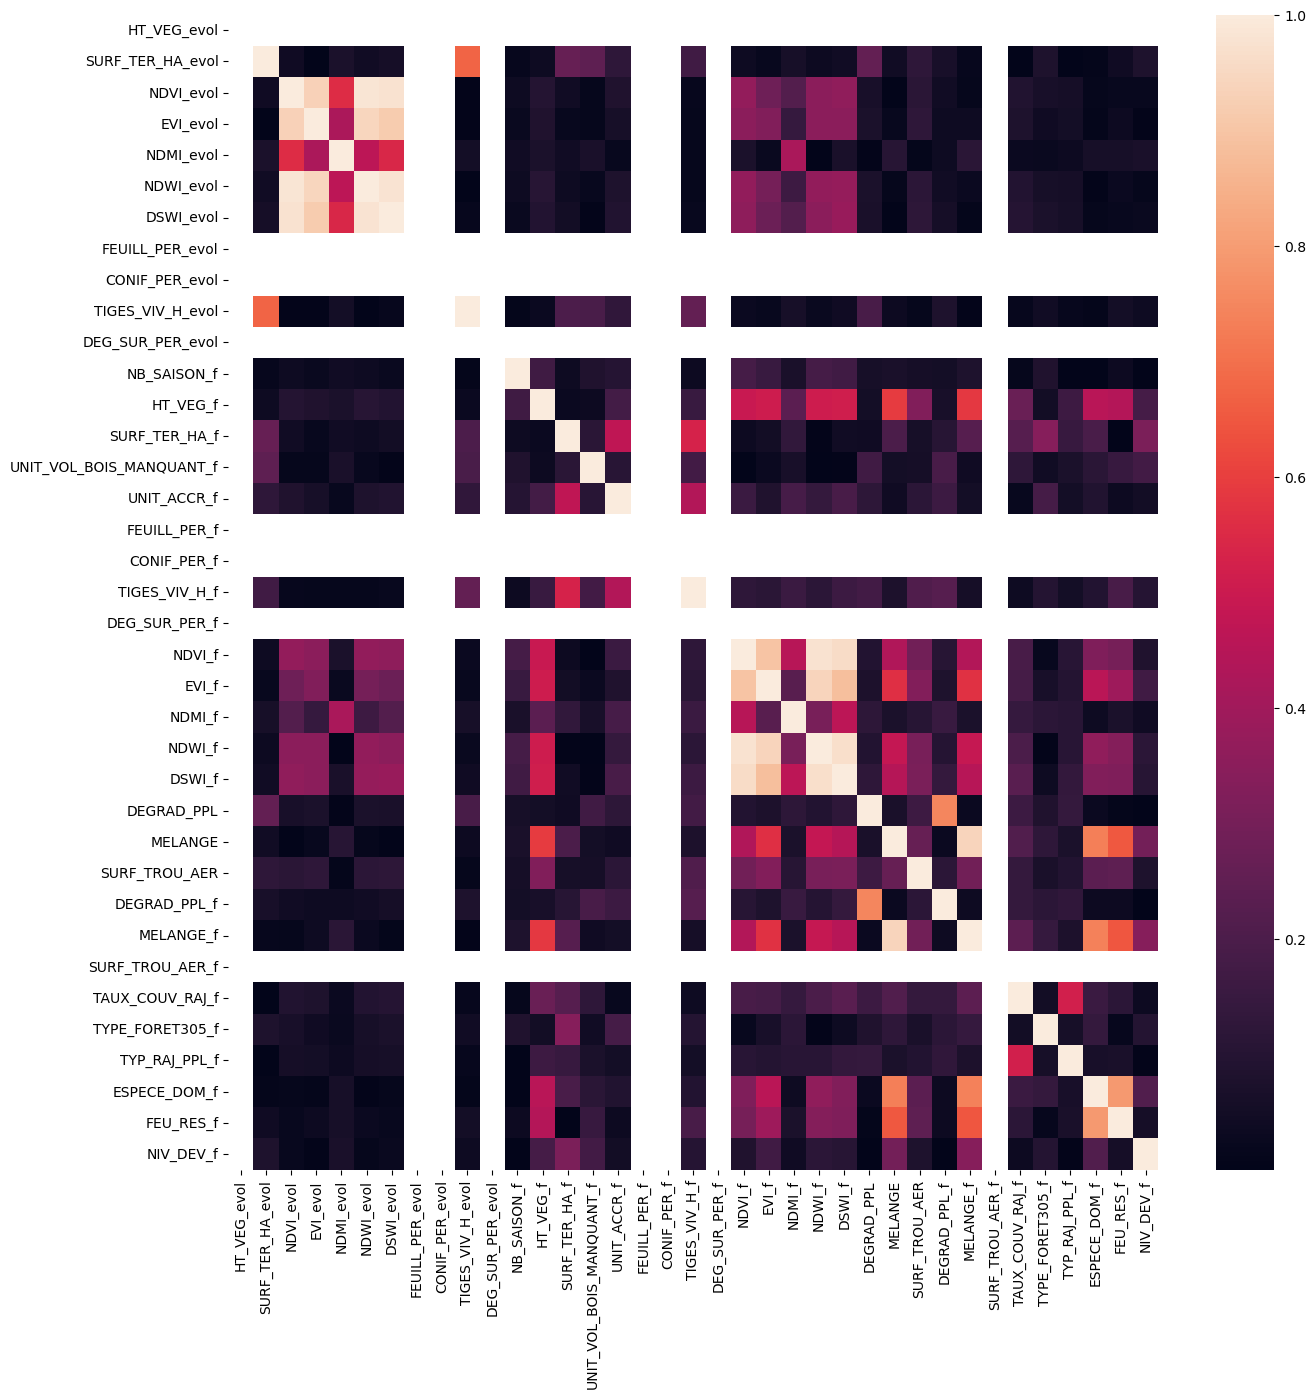

In [125]:
data_corr = data_red_red.corr()
fig = plt.figure(figsize=(15,15))
sns.heatmap(abs(data_corr))